# 树回归算法
一、数据建模问题 
前面介绍了贪心算法的决策树，构建算法是ID3，每次选取当前最佳特征来分割数据，并且按照这个特征的所有可能取值来划分，一旦切分完成，这个特征在之后的执行过程中不会再有任何用处。这种方法切分过于迅速，并且需要将连续型数据离散化后才能处理，这样就破坏了连续变量的内在性质。 
二元切分法是另一种树构建算法，每次将数据集切分成两半，如果数据的某个特征满足这个切分的条件，就将这些数据放入左子树，否则右子树。CART（Classification And Regression Trees，分类回归树）使用二元切分来处理连续型变量，并用总方差取代香农熵来分析模型的效果。 
使用字典存储树的数据结构，每个节点包含以下四个元素：待切分的特征、待切分的特征值、左子树、右子树。 
创建树的代码可以重用，伪代码大致如下。

找到最佳的待切分特征： 
    如果该节点不能再分，将该节点存为叶节点 
    执行二元切分 
    在左右子树分别递归调用

binSplitDataSet通过数组过滤切分数据集，createTree递归建立树，输入参数决定树的类型，leafType给出建立叶节点的函数，因此该参数也决定了要建立的是模型树还是回归树，errType代表误差计算函数，ops是一个包含树构建所需的其他参数的元组

In [1]:
from numpy import *

In [2]:
## 读取数据
def loadDataSet(fileName):
    """
    读取数据
    参数：
        fileName -- 文件名
    参数：
        dataMat -- 数据矩阵
    """
    dataMat = []                                 # 新建数据矩阵
    fr = open(fileName)
    for line in fr.readlines():                  
        curLine = line.strip().split('\t')       # 以制表符分割
        fltLine = list(map(float,curLine))       #将数据行映射为浮点数
        dataMat.append(fltLine)
    return dataMat

In [3]:
def binSplitDataSet(dataSet, feature, value):
    """
    二分割数据
    参数：
        dataSet -- 数据集
        feature -- 分割特征
        value --   分割点
    返回：
        mat0 -- 矩阵1
        mat1 -- 矩阵2
    """
    #if len(nonzero(dataSet[:,feature] > value)[0]) == 0:
    #    return array([]), array([])
    mat0 = dataSet[nonzero(dataSet[:,feature] > value)[0],:]
    mat1 = dataSet[nonzero(dataSet[:,feature] <= value)[0],:]
    return mat0,mat1

In [9]:
testMat=mat(eye(4))
print(testMat)
mat0,mat1=binSplitDataSet(testMat,1,0.5)
print(mat0)
print(mat1)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[0. 1. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


## 回归树（CART算法）
#### 支持函数

In [4]:
""" 计算目标变量均值"""                                                      # regLeaf（）负责生成叶节点
def regLeaf(dataSet):                                                      #当函数chooseBestSplit（）确定不再对数据进行切分时使用
    return mean(dataSet[:,-1])                                             #计算目标变量的均值
                                                                           # 子叶上没有分割特征和分割阈值，仅有子集中目标变量的均值
    
""" 计算目标变量总方差 """                                                   #误差估计函数Err（）
def regErr(dataSet):                                                       #the choice of the best feature is driven by Reduction in RSS error from mean of target varialble
    return var(dataSet[:,-1]) * shape(dataSet)[0]                          #均方差函数var， 乘以样本量得到总方差

""" 选择最佳切分特征 """                                                    #遍历所有特征及其可能的取值来找到使误差最小化的切分阈值（找到数据的最佳二分切分方式）
def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    """ 
    输入：1、dataSet——数据集（m行xn列）
                2、leafType  ——  建立叶节点函数的引用
                3、errType——     误差计算函数的引用 
                4、ops——其他参数（元组）第一个为容许的误差下降值，第二个为切分出的最小样本数  用于控制函数的停止时机
    输出：1、bestIndex——最佳用来切分的特征（列索引）
                2、bestValue——特征值
    """
    tolS = ops[0];                                                           # 容许的误差下降值
    tolN = ops[1]                                                            # 切分出的最小样本数
    if len(set(dataSet[:,-1].T.tolist()[0])) == 1:                           # 如果剩余1个特征则退出（1）
        return None, leafType(dataSet)                                       # 函数返回none的同时，调用建立叶节点的函数leafType
                                                                             # 子叶上没有分割特征和分割阈值，仅有子集中目标变量的均值
        
    m,n = shape(dataSet)                                                     # 训练数据的行与列                                                                     
    S = errType(dataSet)                                                     # 当前数据集的误差，调用误差计算函数errType（）
    bestS = inf; bestIndex = 0; bestValue = 0                                # 初始化最小误差、最佳分割特征、最佳分割特征值（阈值）
    for featIndex in range(n-1):                                             # 遍历所有特征
        for splitVal in set(dataSet[:,featIndex].T.A.tolist()[0]):           # 遍历该特征的所有值   mat.T为矩阵转置，mat.A为矩阵转为数组，等价于getA(), array.tolist() 将数组转化为列表
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)       # 利用binSplitDataSet()进行切分
            if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN): continue  # 跳过样本数<阈值的切分
            newS = errType(mat0) + errType(mat1)                             # 计算当前切分下的两组样本集的误差和
            if newS < bestS:                                                 # 若当前分割的误差较小
                bestIndex = featIndex                                        # 采用当前特征为最佳分割特征
                bestValue = splitVal                                         # 采用当前阈值
                bestS = newS                                                 # 更新最佳分割的方差
                                                                             # 最佳切分即使得切分后能达到最低误差

                                                                             # 误差减小量小于阈值则退出（2） # 如果分割的效果提升没有超过一定数值，就没有必要进行分割
    if (S - bestS) < tolS: 
        return None, leafType(dataSet) 
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)              # 根据最佳分割进行分割
    
                                                                             # 如果根据最佳分割切分出的两个数据集其中一个的样本量太小则退出（3）
    if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN): 
        return None, leafType(dataSet)
    return bestIndex,bestValue


### 生成树的算法

In [5]:
def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    """
    建立树
    参数：
        dataSet -- 数据集
        leafType -- 叶子类型
        errType -- 误差类型
        ops -- 参数元组
    返回：
        retTree -- 返回的树
    """
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)           # 选择当前dataSet数据集的最佳分割点 ，feat为分割特征，val为分割特征的阈值
    if feat == None: 
        return val                                                         # 如果达到迭代停止条件，返回val（终止递归的条件）
                                                                           #（1）剩余1个待分割特征
                                                                           #（2）误差减小量小于指定值
                                                                           #（3）根据最佳分割切分出的两个数据集其中一个的样本量太小
                
    retTree = {}                                                           # 新建子树字典
    retTree['spInd'] = feat                                                # 树节点所对应的特征
    retTree['spVal'] = val                                                 # 树节点所对应的特征值（阈值）
    lSet, rSet = binSplitDataSet(dataSet, feat, val)                       # 二分割
                                                                           # 左右子树
    retTree['left'] = createTree(lSet, leafType, errType, ops)             # 每个子树继续进行递归
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree 

In [42]:
dat1 = loadDataSet('C:/Users/Administrator/ex00.txt')
dat1 = mat(dat1)
createTree(dat1)                                                          #结果得到表示回归树的字典
                                                                          #spInd代表分割特征，spVal为分割的阈值
                                                                          #left为该节点下小于阈值的树，right为大于阈值的数

{'spInd': 0,
 'spVal': 0.48813,
 'left': 1.0180967672413792,
 'right': -0.04465028571428572}

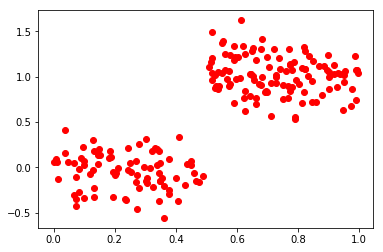

In [43]:
import matplotlib.pyplot as plt 
myDat=loadDataSet('ex00.txt') 
myMat=mat(myDat) 
createTree(myMat) 
plt.plot(myMat[:,0],myMat[:,1],'ro' )
plt.show()

In [20]:
dat2 = loadDataSet('C:/Users/Administrator/ex2.txt')
dat2 = mat(dat2)
createTree(dat2)

{'spInd': 0,
 'spVal': 0.499171,
 'left': {'spInd': 0,
  'spVal': 0.729397,
  'left': {'spInd': 0,
   'spVal': 0.952833,
   'left': {'spInd': 0,
    'spVal': 0.958512,
    'left': 105.24862350000001,
    'right': 112.42895575000001},
   'right': {'spInd': 0,
    'spVal': 0.759504,
    'left': {'spInd': 0,
     'spVal': 0.790312,
     'left': {'spInd': 0,
      'spVal': 0.833026,
      'left': {'spInd': 0,
       'spVal': 0.944221,
       'left': 87.3103875,
       'right': {'spInd': 0,
        'spVal': 0.85497,
        'left': {'spInd': 0,
         'spVal': 0.910975,
         'left': 96.452867,
         'right': {'spInd': 0,
          'spVal': 0.892999,
          'left': 104.825409,
          'right': {'spInd': 0,
           'spVal': 0.872883,
           'left': 95.181793,
           'right': 102.25234449999999}}},
        'right': 95.27584316666666}},
      'right': {'spInd': 0,
       'spVal': 0.811602,
       'left': 81.110152,
       'right': 88.78449880000001}},
     'right': 102.

### 树剪枝
#### 预剪枝（prepruning）

In [23]:
#通过修改停止条件得到结果
dat2 = loadDataSet('C:/Users/Administrator/ex2.txt')
dat2 = mat(dat2)
createTree(dat2,ops=(10000,5))

{'spInd': 0,
 'spVal': 0.499171,
 'left': 101.35815937735848,
 'right': -2.637719329787234}

####  后剪枝（postpruning）
使用后剪枝方法需要将数据集分为测试集和训练集。
1.首先指定createTree（）的ops参数，使得构建出来的树足够复杂便于剪枝
2.从上而下找到叶节点，用测试集来判断这些叶节点合并是否能够降低测试误差
函数prune（）的伪代码如下：
基于已有的树切分测试数据：
    如果存在任一子集是一棵树，则在该子集递归剪枝过程
    计算当前两个叶节点合并后的误差
    计算不合并的误差
    如果合并会降低测试误差的话，就将叶节点合并
##### 支持函数

In [6]:
def isTree(obj):                                                      # 测试该节点是否为一课树，返回布尔结果
    return (type(obj).__name__=='dict')
def getMean(tree):                                                    # 递归函数，从上而下遍历tree直到它的叶节点为止
    if isTree(tree['right']):                                         # 判断该节点是否有右子树
        tree['right'] = getMean(tree['right'])                        # 有则继续在右子树递归
    if isTree(tree['left']):                                          # 判断该树是否有左子树
        tree['left'] = getMean(tree['left'])                          # 有则继续在左子树递归
                                                                      # 递归直至节点不满足上述两种情况（即tree[right]和tree[lesf]为两个叶子时）
    return (tree['left']+tree['right'])/2.0                           # 找到两个叶节点则计算他们的平均值
                                                                      # 该函数对树进行坍塌处理（返回树平均值）

#### 后剪枝函数

In [7]:
def prune(tree, testData):                                                      # 递归函数
    """
    剪枝函数
    参数：
        tree --     待剪枝的（子）树
        testData -- 剪枝所需的测试数据（子集）
    返回：
        treeMean -- 合并的结果（左右子叶合并后的目标变量均值）
        或
        tree     -- 不需要剪枝（没有进行剪枝的子树）
    """
    if shape(testData)[0] == 0: 
        return getMean(tree)                                                    # 如果没有测试数据，就直接把整棵树合并，对树进行坍塌处理（返回树平均值）
                                                                                # 若为非空，则递归调用prune对数据集进行切分
        
    if (isTree(tree['right']) or isTree(tree['left'])):                         # 判断某个分支是否为子树，是则对测试数据集进行分割  
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])    # 得到分割后的两个数据集
        
    if isTree(tree['left']):                                                    # 左子树对分割后的左子数据集递归prune()分割
        tree['left'] = prune(tree['left'], lSet)           
    if isTree(tree['right']):                                                   # 右子树对分割后的右子数据集递归prune()分割
        tree['right'] =  prune(tree['right'], rSet)
    
    if not isTree(tree['left']) and not isTree(tree['right']):                  # 递归直至如果发现左右子树都是叶子节点，则判断是否要合并
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])    # 先分割
       
        errorNoMerge = sum(power(lSet[:,-1] - tree['left'],2)) +sum(power(rSet[:,-1] - tree['right'],2))    # 不合并时，两个叶的误差和（总方差和）
                                                                                                            # 子叶上没有分割特征和分割阈值，仅有子集中目标变量的均值
        treeMean = (tree['left']+tree['right'])/2.0
        errorMerge = sum(power(testData[:,-1] - treeMean,2))                                                # 合并两个叶的总方差
        
        if errorMerge < errorNoMerge:                                           # 如果合并后，误差减小，则执行合并                                    
            print("merging")
            return treeMean                                                                                 
        else: 
            return tree                                                         # 反之，不执行合并
    else: return tree

In [35]:
myDat2 = loadDataSet("ex2.txt")
myMat2 = mat(myDat2)
myTree = createTree(myMat2, ops=(0, 1))
myDatTest = loadDataSet("ex2test.txt")
myMat2Test = mat(myDatTest)
prune(myTree, myMat2Test)

merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging
merging


{'spInd': 0,
 'spVal': 0.499171,
 'left': {'spInd': 0,
  'spVal': 0.729397,
  'left': {'spInd': 0,
   'spVal': 0.952833,
   'left': {'spInd': 0,
    'spVal': 0.965969,
    'left': 92.5239915,
    'right': {'spInd': 0,
     'spVal': 0.956951,
     'left': {'spInd': 0,
      'spVal': 0.958512,
      'left': {'spInd': 0,
       'spVal': 0.960398,
       'left': 112.386764,
       'right': 123.559747},
      'right': 135.837013},
     'right': 111.2013225}},
   'right': {'spInd': 0,
    'spVal': 0.759504,
    'left': {'spInd': 0,
     'spVal': 0.763328,
     'left': {'spInd': 0,
      'spVal': 0.769043,
      'left': {'spInd': 0,
       'spVal': 0.790312,
       'left': {'spInd': 0,
        'spVal': 0.806158,
        'left': {'spInd': 0,
         'spVal': 0.815215,
         'left': {'spInd': 0,
          'spVal': 0.833026,
          'left': {'spInd': 0,
           'spVal': 0.841547,
           'left': {'spInd': 0,
            'spVal': 0.841625,
            'left': {'spInd': 0,
            

## 模型树
相对于叶节点为目标变量的均值的回归树，模型树把叶节点设定为分段线性函数（piecewise linear），指模型由多个线性片段组成

In [11]:
def linearSolve(dataSet):
    """
    标准线性回归模型
    参数：
        dataSet -- 数据集
    返回：
        ws -- 回归参数
        X -- x数据
        Y -- y数据
    """
    m,n=shape(dataSet)                                             # 获取数据行与列数
    X=mat(ones((m,n)))                                             # 初始化训练样本矩阵          
    Y=mat(ones((m,1)))                                             # 初始化lebal向量
    X[:,1:n]=dataSet[:,0:n-1]                                      # 数据集矩阵的第一列初始化为1，偏置项；
    Y=dataSet[:,-1]                                                # 每个样本目标变量值存入Y
    
    xTx=X.T*X                                                      #对数据集矩阵求内积
    if linalg.det(xTx)==0.0:                                       #计算行列式值是否为0，即判断是否可逆
        print('This matrix is singular,cannot do inverse,\n\try increasing the second value if ops')       #不可逆，打印信息
    ws=(xTx).I*(X.T*Y)                                             #可逆，计算回归系数
    return ws,X,Y                                                  #返回回顾系数;数据集矩阵;目标变量值矩阵

In [12]:
def modelLeaf(dataSet):                        #当数据不再需要切分的时候负责生成叶节点的模型
    """
    模型树的叶节点模型
    参数：
        dataSet -- 数据集
    返回：
        ws -- 回归参数
    """
    ws,X,Y=linearSolve(dataSet)                #调用线性回归函数生成叶节点模型
    return ws                                  #返回该叶节点线性方程的回顾系数

def modelErr(dataSet):                         #在给定的数据集上计算误差，返回y与yHat之间的平方误差
    """
    模型树的误差计算函数
    """
    ws,X,y=linearSolve(dataSet)                #构建模型树叶节点的线性方程，返回参数
    yHat=X*ws                                  #利用线性方程对数据集进行预测
    return sum(power(y-yHat,2))                #返回误差的平方和，平方损失


In [13]:
#测试
myMat2 = mat(loadDataSet("exp2.txt"))
createTree(myMat2, modelLeaf, modelErr, (1, 10))

{'spInd': 0, 'spVal': 0.285477, 'left': matrix([[1.69855694e-03],
         [1.19647739e+01]]), 'right': matrix([[3.46877936],
         [1.18521743]])}

### 示例：树回归与标准回归的比较


In [16]:
def isTree(obj):
    return (type(obj).__name__=='dict')

""" 对回归树叶节点进行预测 """
def regTreeEval(model, inDat):
    return float(model)                            # 回归树的叶节点即为均值

""" 对模型树叶节点进行预测 """
def modelTreeEval(model, inDat):
    n = shape(inDat)[1]
    X = mat(ones((1,n+1)))
    X[:,1:n+1]=inDat                               # 与上1行的共同作用是对原始数据集第一列前增加值为1的一列，作为偏置项
    return float(X*model)                          # X与系数W的乘积即为预测值


In [17]:
""" 自顶向下遍历树，返回叶节点预测值 """
def treeForeCast(tree, inData, modelEval=regTreeEval):
    """ 
    输入： 1、tree——树结构
          2、inData——输入数据（单点或行向量）
          3、modelEval——对叶节点数据进行预测函数的引用
    输出：叶节点预测值
    """
    if not isTree(tree): 
        return modelEval(tree, inData)                                                 # 叶子节点直接返回预测值，modelEval为回归树或者模型树的叶节点预测模型
    if inData[tree['spInd']] > tree['spVal']:                                          # 测试（子）集在节点上大于阈值
        if isTree(tree['left']):                                                       # 左子树存在
            return treeForeCast(tree['left'], inData, modelEval)                       # 则对左子树继续递归                          
        else:
            return modelEval(tree['left'], inData)                                     # 否则按选取的模型返回预测值
        
    else:                                                                              # 测试（子）集在节点上小于阈值   
        if isTree(tree['right']):                                                      # 若右子树存在
            return treeForeCast(tree['right'], inData, modelEval)                      # 则对右子树继续递归
        else: return modelEval(tree['right'], inData)                                  # 否则按选取的模型返回预测值

In [18]:
""" 对一组测试数据集计算预测值 """
def createForeCast(tree, testData, modelEval=regTreeEval):
    """ 
    输入：1、tree——树结构
          2、testData——测试数据集
           3、modelEval——对叶节点数据进行预测函数的引用
    输出：yHat——一组预测值（行向量）
    """
    m = len(testData)
    yHat = mat(zeros((m,1)))
    for i in range(m):                                                                # 遍历所有测试样本
        yHat[i,0] = treeForeCast(tree, mat(testData[i]), modelEval)                   # 预测
    return yHat

##### 进行比较

In [33]:
trainMat = mat(loadDataSet('bikeSpeedVsIq_train.txt'))                                # 训练数据
testMat = mat(loadDataSet('bikeSpeedVsIq_test.txt'))                                  # 测试数据

In [34]:
""" 回归树 """
myTree = createTree(trainMat, ops=(1,20))                                             # 建立回归树模型
yHat = createForeCast(myTree, testMat[:,0])                                           # 预测
corrcoef(yHat, testMat[:,1], rowvar=0)[0,1]                                           # 复相关系数

0.9640852318222148

In [35]:
""" 模型树 """
myTree = createTree(trainMat, modelLeaf, modelErr,ops=(1,20))                         # 建立模型树模型
yHat = createForeCast(myTree, testMat[:,0], modelTreeEval)                            # 预测
corrcoef(yHat, testMat[:,1], rowvar=0)[0,1]                                           # 复相关系数

0.976041219138063

In [36]:
""" 标准线性回归 """
import numpy as np
ws, X, Y = linearSolve(trainMat)
shape(np.mat(ws.getA()))
yMat=np.dot(X,ws)
corrcoef(yHat, testMat[:,1], rowvar=0)[0,1]

0.976041219138063

由上述结果可知，在复相关系数度量下，三种方法优略如下：
标准线性回归<回归树<模型树

# 用Tkinter实现Python GUI

In [37]:
from tkinter import *

In [38]:
root = Tk()
myLabel = Label(root, text='Hello world!')
myLabel.grid()
root.mainloop()

## 用于构建管理界面的Tkinter小部件

In [40]:
from numpy import *

In [41]:
import matplotlib
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

In [42]:
def reDraw(tolS,tolN):
    reDraw.f.clf()        # clear the figure
    reDraw.a = reDraw.f.add_subplot(111)
    if chkBtnVar.get():
        if tolN < 2: tolN = 2
        myTree=createTree(reDraw.rawDat, modelLeaf,modelErr, (tolS,tolN))
        yHat = createForeCast(myTree, reDraw.testDat, modelTreeEval)
    else:
        myTree=createTree(reDraw.rawDat, ops=(tolS,tolN))
        yHat = createForeCast(myTree, reDraw.testDat)
    reDraw.a.scatter(reDraw.rawDat[:,0].A, reDraw.rawDat[:,1].A, s=5) #use scatter for data set
    reDraw.a.plot(reDraw.testDat, yHat, linewidth=2.0) #use plot for yHat
    reDraw.canvas.draw()
    
def getInputs():
    try: tolN = int(tolNentry.get())
    except: 
        tolN = 10 
        print("enter Integer for tolN")
        tolNentry.delete(0, END)
        tolNentry.insert(0,'10')
    try: tolS = float(tolSentry.get())
    except: 
        tolS = 1.0 
        print("enter Float for tolS")
        tolSentry.delete(0, END)
        tolSentry.insert(0,'1.0')
    return tolN,tolS
 
def drawNewTree():
    tolN,tolS = getInputs()#get values from Entry boxes
    reDraw(tolS,tolN)



In [43]:
root = Tk()
#用画布来替换绘制占位符，并删掉对应标签，即下面的Plot Place Holder那句
reDraw.f = Figure(figsize = (5,4),dpi = 100)
reDraw.canvas = FigureCanvasTkAgg(reDraw.f, master=root)
reDraw.canvas.draw()
reDraw.canvas.get_tk_widget().grid(row = 0,columnspan = 3)
#待删除，只是代替图片占一个位置
#Label(root,text='Plot Place Holder').grid(row = 0, columnspan = 3)
#tolN
Label(root,text = 'tolN').grid(row = 1, column = 0)
tolNentry = Entry(root)  #Entry：单行文本输入框
tolNentry.grid(row=1, column = 1)
tolNentry.insert(0,'10')     #默认值为10
#tolS
Label(root,text = 'tolS').grid(row = 2, column = 0)
tolSentry = Entry(root)
tolSentry.grid(row=2, column = 1)
tolSentry.insert(0,'1.0')     #默认值为1.0
#按钮
Button(root,text = 'ReDraw',command = drawNewTree).grid(row = 1, column = 2,rowspan = 3)
#按钮整数值
chkBtnVar = IntVar()
#复选按钮
chkBtn = Checkbutton(root,text = 'Model Tree',variable = chkBtnVar)
chkBtn.grid(row = 3, column = 0,columnspan = 2)
#初始化数据
reDraw.rawDat = mat(loadDataSet('sine.txt'))
reDraw.testDat = arange(min(reDraw.rawDat[:,0]),max(reDraw.rawDat[:,0]),0.01)
reDraw(1.0,10)
root.mainloop()